# Experiment Tracking (WandB, Comet ML)

In [1]:
# Some imports

# computation stuff
import torch
import numpy as np

# plotting stuff
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina' # makes the quality higher

import seaborn as sns
sns.set_style("whitegrid") # improves the quality of matplotlib images and adds grid

# DNN Training pipeline (for reference)

Before we go to the main part, let's reuse code from previous time:

In [2]:
from torch.utils.data import DataLoader, Dataset

In [3]:
import torchvision
from torch import nn

In [4]:
transform = torchvision.transforms.Compose( # Sequential application of transforms, for this example it is unnecessarily
    [
        torchvision.transforms.ToTensor(), # from Image class to Tensor
    ]
)

In [5]:
mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=transform
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17704313.11it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 483351.80it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4449258.23it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4271419.01it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



torch.Size([1, 28, 28])


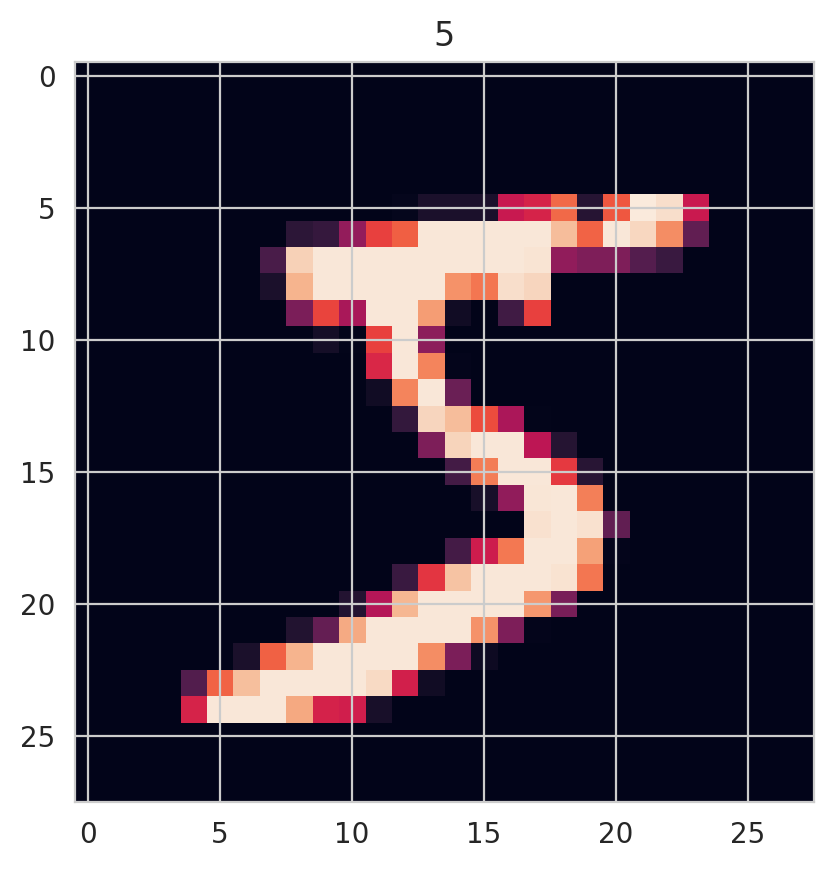

In [6]:
example_img, example_label = mnist_train[0]
print(example_img.shape) # C x H x W, 1 channel -- grayscale image
plt.imshow(example_img[0])
plt.title(example_label)
plt.show()

In [7]:
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=128, shuffle=False)

In [8]:
class FCNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.net = nn.Sequential(
            nn.Flatten(), # reshape input from C x H x W to 1D-vector
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [9]:
class ConvNetwork(nn.Module):

    def __init__(self, input_channels, hidden_channels, output_size, image_sizes):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(), # to do classification we flatten
            # you need to calculate the flatten size
            nn.Linear(hidden_channels * image_sizes[0] * image_sizes[1], output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [10]:
class ResBlock(nn.Module):

    def __init__(self, input_channels, hidden_channels):
        super().__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=(3,3), stride=1, padding=1),
            nn.ReLU(),
        )

        self.downsample = None
        if input_channels != hidden_channels:
            self.downsample_conv = nn.Conv2d(input_channels, hidden_channels, kernel_size=1)

    def forward(self, x):
        output = self.convs(x)
        if self.downsample is not None:
            # sometimes output + x won't work due to shape mismatch
            # for example if height and width does not match
            # or if channels does not match (if we have only single channel it will work though, but in general won't)
            x = self.downsample(x)
        return output + x # residual connection


class ResNetwork(nn.Module):

    def __init__(self, input_channels, hidden_channels, output_size, image_sizes):
        super().__init__()

        self.net = nn.Sequential(
            ResBlock(input_channels, hidden_channels),
            ResBlock(hidden_channels, hidden_channels),
            nn.Flatten(), # to do classification we flatten
            # you need to calculate the flatten size
            nn.Linear(hidden_channels * image_sizes[0] * image_sizes[1], output_size),
        )

    def forward(self, input_data):
        return self.net(input_data)

In [11]:
fc_net = FCNetwork(example_img.flatten().shape[0], 128, 10) # 10 labels
print(fc_net)

FCNetwork(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [12]:
conv_net = ConvNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
print(conv_net)

ConvNetwork(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=25088, out_features=10, bias=True)
  )
)


In [13]:
res_net = ResNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
print(res_net)

ResNetwork(
  (net): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
      (downsample_conv): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ResBlock(
      (convs): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=25088, out_features=10, bias=True)
  )
)


In [14]:
criterion = nn.CrossEntropyLoss()

### Training pipeline

In [15]:
from IPython import display

In [16]:
from tqdm.auto import tqdm

In [17]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to train mode during training
    model.train()

    avg_loss = 0
    for batch_idx, (image, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        loss.backward() # calculate gradients
        optimizer.step() # update weights
        optimizer.zero_grad() # zero gradients for the next step
        scheduler.step() # update learning rate

        avg_loss += loss.item() # item to detach loss and get element on CPU
        # item is used for tensors containing single scalar

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    return avg_loss


def evaluate(model, dataloader, criterion, device):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to eval mode during inference
    model.eval()

    avg_loss = 0
    accuracy = 0
    total_elements = 0
    for batch_idx, (image, label) in enumerate(dataloader):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        # you should also calculate some metrics, like accuracy
        accuracy += (output.argmax(-1) == label).sum().item()
        total_elements += output.shape[0] # we will use it to calculate accuracy
        avg_loss += loss.item()

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    accuracy = 100 * accuracy / total_elements
    return avg_loss, accuracy


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, n_epochs):

    train_avg_losses = []
    val_avg_losses = []
    val_accuracy_list = []
    for epoch in range(n_epochs):
        train_avg_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, scheduler, device)
        val_avg_loss, val_accuracy = evaluate(model, val_dataloader, criterion, device)

        # some logging

        # clear output so to redraw the plot
        display.clear_output(wait=True)

        train_avg_losses.append(train_avg_loss)
        val_avg_losses.append(val_avg_loss)
        val_accuracy_list.append(val_accuracy)

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].plot(train_avg_losses, color="blue", label="train")
        axes[0].plot(val_avg_losses, color="red", label="val")
        axes[0].set_xlabel("Epoch number")
        axes[0].set_ylabel("Loss")
        axes[0].set_title(f"Min train loss: {round(min(train_avg_losses), 5)}, min val loss: {round(min(val_avg_losses), 5)}")

        axes[1].plot(val_accuracy_list, color="red", label="val")
        axes[1].set_xlabel("Epoch number")
        axes[1].set_ylabel("Accuracy (%)")
        axes[1].set_title(f"Best Accuracy (%): {max(val_accuracy_list)}")

        plt.legend()
        plt.tight_layout()
        plt.show()

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu" # "cuda" -- use GPU, "cpu" -- use CPU
print(device)

cuda


In [19]:
NUM_EPOCHS = 10

In [20]:
# FC net

# do not forget to put the model itself on device
fc_net = FCNetwork(example_img.flatten().shape[0], 128, 10) # 10 labels
fc_net.to(device)

# define optimizer and scheduler to update weights and learning rate, respectively
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

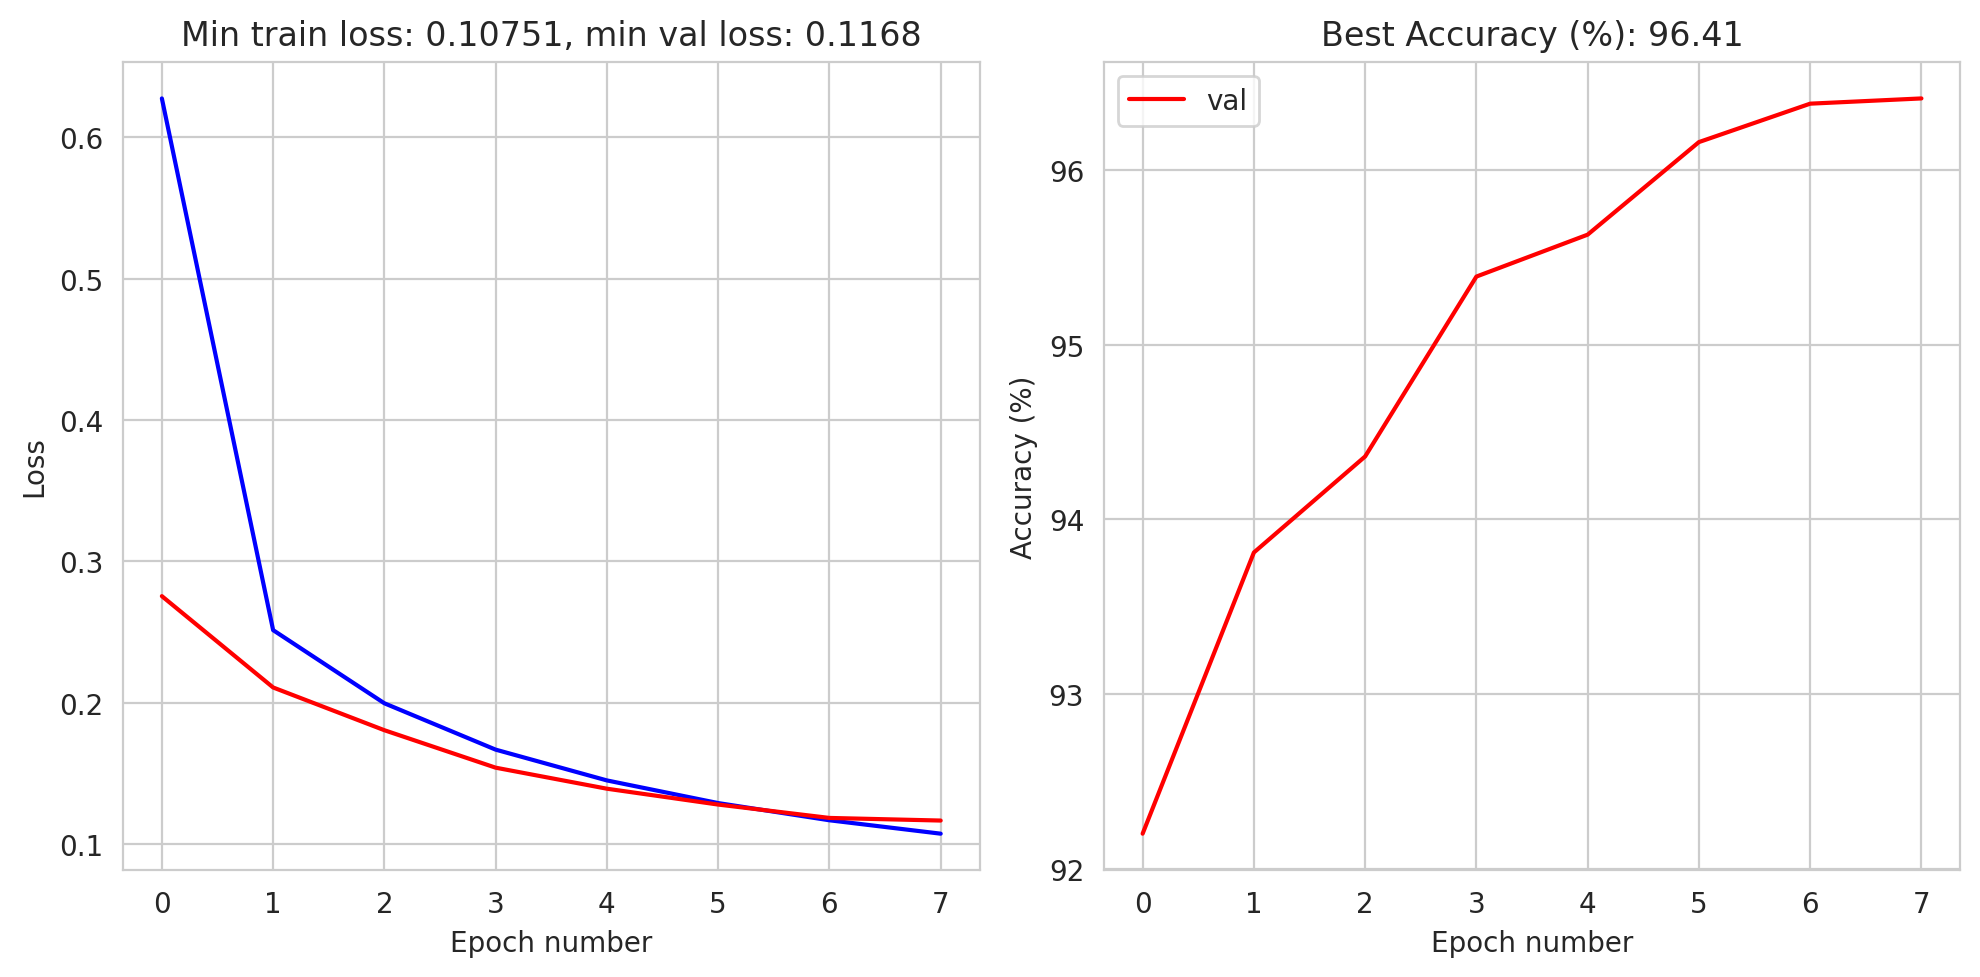

In [ ]:
train(fc_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

In [ ]:
# Conv net

# do not forget to put the model itself on device
conv_net = ConvNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
conv_net.to(device)

optimizer = torch.optim.Adam(conv_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

In [ ]:
train(conv_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

# Logging (WandB and friends)

While training the model, it is useful to monitor several aspects:

1. What is the quality of our model? Does it overfit on training data?
2. Should we stop the training or continue?
3. Does the model input looks reasonable or we corrupted it too severely?
4. What is the learning rate, is it too small or good enough?
5. etc.

All these stuff is required to effectively use the computational resources and properly design data processing pipeline and model training scheme. To do this, we should add logging.

Until now, we logged everything using hand-crafted calculations and plotting. This have several disadvantages:

1. A lot of extra code only for logging purposes. Plotting too much stuff might be hard
2. Simultaneously visualizing different types of data (audio and text, or text and images) together with all the plots is complicated
3. Comparing plots between models or different runs of the same model requires writing code to save logs and code to load these logs and visualize all the data again

**TL;DR:** While doing everything by yourself is possible, it is not efficient.

----

There exist several visualization tools. Here are some of them with **subjective** comments:

* [WandB](https://wandb.ai/site) -- easy to use and cool website to monitor logs from **different machines** (cloud-hosted)
* [Comet ML](https://www.comet.com/site/) -- similar to WandB with a bit smaller functionality (cloud-hosted)
* [MLflow](https://mlflow.org/) -- easy to use but UI is less intuitive and it is harder to compare logs from different machines (self-hosted)
* [TensorBoard](https://www.tensorflow.org/tensorboard) -- rather old but still popular, might consume a lot of resources (from seminar author's experience). However, it contains unique cool features like **profiler support** (see [here](https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html)). (self-hosted)
* [aim](https://github.com/aimhubio/aim) -- seminar author has not try it, but it is **open-source** which is cool (self-hosted)
* [ClearML](https://github.com/allegroai/clearml) -- seminar author have not try it, but it contains **tons of different features**. Similar to WandB and Comet but free account has more restrictions (cloud-hosted).

We will focus on **WandB** and **Comet ML** in this seminar, but the general usage API is similar within these tools. Let's rewrite our pipeline with WandB

In [25]:
!pip install wandb
# to begin with, you should create an account on WanbB website

import wandb

# this will ask your for your API key
wandb.login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

See how we deleted a lot of hand-crafted logging code and were able to log more stuff without problems in just a few lines:

In [26]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, device, epoch):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to train mode during training
    model.train()

    avg_loss = 0
    step = epoch * len(dataloader) # current step
    for batch_idx, (image, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        loss.backward() # calculate gradients
        optimizer.step() # update weights
        optimizer.zero_grad() # zero gradients for the next step
        scheduler.step() # update learning rate

        avg_loss += loss.item() # item to detach loss and get element on CPU
        # item is used for tensors containing single scalar

        # the simplicity of wandb logging allows us to easily add more logging
        # and do not care about plotting functions too much
        wandb.log({
            "train_step_loss": loss.item(),
            "lr": scheduler.get_last_lr()[0] # get current lr for the 0th param group
        }, step=step + batch_idx)

        # we can also log images, for example
        if batch_idx == 0: # let's log only the first batch
            # sometimes you may need to use matplotlib wrapper around your image
            # to make sure it is visualized correctly
            # for example if your image tensor is in [-1, 1] and not [0, 1]. Be careful

            wandb.log({"train_image": wandb.Image(image[0])}, step=step+batch_idx)

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    return avg_loss


def evaluate(model, dataloader, criterion, device):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to eval mode during inference
    model.eval()

    avg_loss = 0
    accuracy = 0
    total_elements = 0
    for batch_idx, (image, label) in enumerate(dataloader):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        # you should also calculate some metrics, like accuracy
        accuracy += (output.argmax(-1) == label).sum().item()
        total_elements += output.shape[0] # we will use it to calculate accuracy
        avg_loss += loss.item()

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    accuracy = 100 * accuracy / total_elements
    return avg_loss, accuracy


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, n_epochs):

    train_avg_losses = []
    val_avg_losses = []
    val_accuracy_list = []

    for epoch in range(n_epochs):
        train_avg_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, scheduler, device, epoch)
        val_avg_loss, val_accuracy = evaluate(model, val_dataloader, criterion, device)

        # some logging

        # No need to write plotting functions
        wandb.log({
            "train_avg_loss": train_avg_loss, # no need to create lists yourself
            "val_avg_loss": val_avg_loss,
            "val_accuracy": val_accuracy,
        }, step=(epoch + 1) * len(train_dataloader)) # this is the total number of steps until now

        # we provide step explicitly because otherwise each logging call will increase inner wandb step variable
        # this allows us to log to the same step from different parts of the code

Wrap your code in `wandb` contextual manager. This makes sure that `wandb` is closed after you pipeline is done or broken. Two arguments "project" and "name" are mandatory. We will show other arguments later

```python
with wandb.init(
                project="seminar_wandb_test", # project name
                name="test_run" # run name within the project
            ) as run:
    train(...) # start training pipeline
```

Let's see examples with FC and Conv nets from previous lesson.

In [27]:
# FC net

# do not forget to put the model itself on device
fc_net = FCNetwork(example_img.flatten().shape[0], 128, 10) # 10 labels
fc_net.to(device)

# define optimizer and scheduler to update weights and learning rate, respectively
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

In [28]:
with wandb.init(
                project="seminar_wandb_test", # project name
                name="fc_net" # run name within the project
            ) as run:
    train(fc_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

wandb: Currently logged in as: aspisov (team-aspisov). Use `wandb login --relogin` to force relogin


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

lr,██████████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train_avg_loss,█▃▂▂▂▁▁▁▁▁
train_step_loss,█▄▅▃▂▃▂▂▂▁▂▂▂▂▂▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇███
val_avg_loss,█▆▄▃▂▂▂▁▁▁
lr,0.0001
train_avg_loss,0.10014
train_step_loss,0.03193
val_accuracy,96.59
val_avg_loss,0.11147


In [29]:
# Conv net

# do not forget to put the model itself on device
conv_net = ConvNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
conv_net.to(device)

optimizer = torch.optim.Adam(conv_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

In [30]:
with wandb.init(
                project="seminar_wandb_test", # project name
                name="conv_net" # run name within the project
            ) as run:
    train(conv_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train_avg_loss,█▃▂▂▁▁▁▁▁▁
train_step_loss,█▇▃▂▅▂▂▃▂▁▂▂▁▁▂▁▁▁▂▃▂▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▆▇▇█████
val_avg_loss,█▃▂▁▂▁▁▁▁▁
lr,0.0001
train_avg_loss,0.02013
train_step_loss,0.01158
val_accuracy,98.72
val_avg_loss,0.04281


We can go to the project page and see several cool features that WandB is providing:

* Automatic comparison of plots
* Comparison of configs\code between runs (if they are logged)
* Automatic logging for system state: GPU utilization, memory utilization, etc.
* Downloading logged data, including saved model parameters (if they are logged)
* WandB Reports

With Comet ML everything is similar. We just need to replace a couple of lines with their Comet ML Version

In [32]:
!pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 11.2 MB/s eta 0:00:00
  Created wheel for configobj: filename=configobj-5.0.9-py2.py3-none-any.whl size=35614 sha256=76bc620dac30c758cc1539293a160ccc9075fe9bc8b4309a832accdaa02bda66
  Stored in directory: /root/.cache/pip/wheels/a1/6c/03/6c5e3cf1a6e4b9e2fc5c4409be4abc5a8268bd9c878739cb32
Successfully built configobj
  Attempting uninstall: python-box
    Found existing installation: python-box 7.2.0
    

In [33]:
# to begin with, you should create an account on Comet ML website

import comet_ml

# this will ask your for your API key
comet_ml.login()

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


In [34]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, device, epoch, exp):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to train mode during training
    model.train()

    avg_loss = 0
    step = epoch * len(dataloader) # current step
    for batch_idx, (image, label) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        loss.backward() # calculate gradients
        optimizer.step() # update weights
        optimizer.zero_grad() # zero gradients for the next step
        scheduler.step() # update learning rate

        avg_loss += loss.item() # item to detach loss and get element on CPU
        # item is used for tensors containing single scalar

        # the simplicity of wandb logging allows us to easily add more logging
        # and do not care about plotting functions too much
        exp.log_metrics({
            "train_step_loss": loss.item(),
            "lr": scheduler.get_last_lr()[0] # get current lr for the 0th param group
        }, step=step + batch_idx)

        # we can also log images, for example
        if batch_idx == 0: # let's log only the first batch
            # sometimes you may need to use matplotlib wrapper around your image
            # to make sure it is visualized correctly
            # for example if your image tensor is in [-1, 1] and not [0, 1]. Be careful

            exp.log_image(image_data=image[0].detach().cpu(), name="train_image", step=step+batch_idx)

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    return avg_loss


def evaluate(model, dataloader, criterion, device):
    # some layers may have different behavior for train and inference
    # this is why it is important to set model to eval mode during inference
    model.eval()

    avg_loss = 0
    accuracy = 0
    total_elements = 0
    for batch_idx, (image, label) in enumerate(dataloader):
        # if we want to use GPU for model forward, we need to put inputs and desired outputs on device
        image, label = image.to(device), label.to(device)

        output = model(image) # calculate model output
        loss = criterion(output, label) # calculate loss

        # you should also calculate some metrics, like accuracy
        accuracy += (output.argmax(-1) == label).sum().item()
        total_elements += output.shape[0] # we will use it to calculate accuracy
        avg_loss += loss.item()

    # batch-idx + 1 == the total number of batches == len(dataloader)
    avg_loss = avg_loss / (batch_idx + 1)
    accuracy = 100 * accuracy / total_elements
    return avg_loss, accuracy


def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, n_epochs, exp):

    # In Comet ML, we can't just call comet_ml.log...,
    # We need to use experiment instance for this, so we add new argument exp

    train_avg_losses = []
    val_avg_losses = []
    val_accuracy_list = []

    for epoch in range(n_epochs):
        train_avg_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, scheduler, device, epoch, exp)
        val_avg_loss, val_accuracy = evaluate(model, val_dataloader, criterion, device)

        # some logging

        # No need to write plotting functions
        exp.log_metrics({
            "train_avg_loss": train_avg_loss, # no need to create lists yourself
            "val_avg_loss": val_avg_loss,
            "val_accuracy": val_accuracy,
        }, step=(epoch + 1) * len(train_dataloader)) # this is the total number of steps until now

        # we provide step explicitly because otherwise each logging call will increase inner wandb step variable
        # this allows us to log to the same step from different parts of the code

`comet_ml` does not support contextual manager. So we should close the experiment ourselves. Initialization of the experiment is similar to `wandb` but we have to define run name in another line. We will show other arguments later

```python
exp = comet_ml.Experiment(project_name="seminar_cometml_test")
exp.set_name("test_run") # run name within the project
train(..., exp)
exp.end()
```

Notice that we could use `wandb.log` without the `run` instance. In `comet_ml`, this is not possible and we have to pass `exp` instance.

Let's see examples with FC and Conv nets from previous lesson.

In [35]:
# FC net

# do not forget to put the model itself on device
fc_net = FCNetwork(example_img.flatten().shape[0], 128, 10) # 10 labels
fc_net.to(device)

# define optimizer and scheduler to update weights and learning rate, respectively
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

In [36]:
# does not support context manager, need to call experiment.end() ourselves

exp = comet_ml.Experiment(project_name="seminar_cometml_test")
exp.set_name("fc_net") # run name within the project
train(fc_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS, exp)

exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/aspisov/seminar-cometml-test/8271039659a74feabae6f9328ff91926



  0%|          | 0/469 [00:00<?, ?it/s]

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : fc_net
COMET INFO:     url                   : https://www.comet.com/aspisov/seminar-cometml-test/8271039659a74feabae6f9328ff91926
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr [4690]              : (0.0001, 0.0002999999775651046)
COMET INFO:     train_avg_loss [10]    : (0.10409848547296356, 0.6398022660949846)
COMET INFO:     train_step_loss [4690] : (0.018236342817544937, 2.303699016571045)
COMET INFO:     val_accuracy [10]      : (91.65, 96.52)
COMET INFO:     val_avg_loss [10]      : (0.11439893594530376, 0.2908363806295998)
COMET INFO:   Others:
COMET INFO:     Name : fc_net
COMET INFO:   Uploads:
COMET INFO:     environment deta

In [37]:
# Conv net

# do not forget to put the model itself on device
conv_net = ConvNetwork(1, 32, 10, image_sizes=example_img.shape[1:]) # 10 labels
conv_net.to(device)

optimizer = torch.optim.Adam(conv_net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS * len(train_dataloader), eta_min=1e-4)

In [38]:
# does not support context manager, need to call experiment.end() ourselves

exp = comet_ml.Experiment(project_name="seminar_cometml_test")
exp.set_name("conv_net") # run name within the project
train(conv_net, train_dataloader, val_dataloader, criterion, optimizer, scheduler, device, NUM_EPOCHS, exp)

exp.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/aspisov/seminar-cometml-test/c7b0daa58570420184d3352fb443e16f



  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : conv_net
COMET INFO:     url                   : https://www.comet.com/aspisov/seminar-cometml-test/c7b0daa58570420184d3352fb443e16f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr [4690]              : (0.0001, 0.0002999999775651046)
COMET INFO:     train_avg_loss [10]    : (0.023322199191798818, 0.3426521166539523)
COMET INFO:     train_step_loss [4690] : (0.0019031823612749577, 2.3070061206817627)
COMET INFO:     val_accuracy [10]      : (96.74, 98.63)
COMET INFO:     val_avg_loss [10]      : (0.04425358801234301, 0.11851409435437261)
COMET INFO:   Others:
COMET INFO:     Name : conv_net
COMET INFO:   Uploads:
COMET INFO:     environm